# Gradient Boosting

## Read in Data

In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error

In [2]:
df = pd.read_csv((
    "https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/"
    "master/ESS_practice_data/ESSdata_Thinkful.csv")).dropna()

# Definine outcome and predictors.
# Set our outcome to 0 and 1.
y = df['partner'] - 1
X = df.loc[:, ~df.columns.isin(['partner', 'cntry', 'idno'])]

# Make the categorical variable 'country' into dummies.
X = pd.concat([X, pd.get_dummies(df['cntry'])], axis=1)

from imblearn.over_sampling import SMOTE

# Instantiate oversampling tool, SMOTE
smote = SMOTE(kind = "regular")

#Oversaple data set 
X_sm, Y_sm = smote.fit_sample(X,y)

# Assign features from oversampled dataset to 'sm_features'
sm_features = pd.DataFrame(data=X_sm,columns=X.columns)

# Assign target variable from oversample dataset to 'sm_target'
sm_target = pd.DataFrame(data=Y_sm, columns = ['partner'])

frames = [sm_features, sm_target]
sm_data = pd.concat(frames,axis=1)

X = sm_features
y = sm_target.values.ravel()

# Create training and test sets.
offset = int(X.shape[0] * 0.7)

# Put 90% of the data in the training set.
X_train, y_train = X[:offset], y[:offset]

# And put 10% in the test set.
X_test, y_test = X[offset:], y[offset:]

## Model

In [6]:
# Initialize list to store t1 errors
t1_errors = []

# Initialize list to store t2 errors
t2_errors = []

In [3]:
from sklearn import grid_search

# Store parameters for grid search
parameters = {'n_estimators':list(range(1,501,50)),'max_depth':list(range(1,11,2)),'loss':('exponential','deviance')}

# Instantiate gradient boost model
gradient_boost = ensemble.GradientBoostingClassifier()

# Instantiate grid search
gs = grid_search.GridSearchCV(gradient_boost, parameters,cv= 3,scoring="accuracy")

# Fit grid search to training data
gs.fit(X_train,y_train)

/Users/wliao/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/wliao/anaconda/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


GridSearchCV(cv=3, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [1, 51, 101, 151, 201, 251, 301, 351, 401, 451], 'max_depth': [1, 3, 5, 7, 9], 'loss': ('exponential', 'deviance')},
       pre_dispatch='2*n_jobs', refit=True, scoring='accuracy', verbose=0)

In [4]:
# Instantiate gradient boost using parameters from grid search
clf = ensemble.GradientBoostingClassifier(**gs.best_params_)

# Fit gradient boost to training data
clf.fit(X_train, y_train)

# Predict outcomes for training + test data
predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

# Accuracy tables.
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))


Training set accuracy:
Percent Type I errors: 0.03662011969222
Percent Type II errors: 0.19663721858079225

Test set accuracy:
Percent Type I errors: 0.02726063829787234
Percent Type II errors: 0.4039228723404255


In [7]:
# Store results
t1_errors.append(test_tI_errors)
t2_errors.append(test_tII_errors)

### Dropping least relevant features

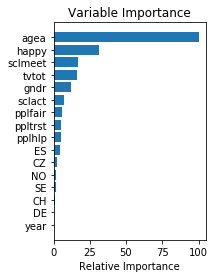

In [8]:
feature_importance = clf.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [9]:
# Drop 5 least relevant features
sm_features.drop(['DE','SE','year','CH','CZ'],axis=1,inplace=True)

X = sm_features
y = sm_target.values.ravel()

# Create training and test sets.
offset = int(X.shape[0] * 0.7)

# Put 90% of the data in the training set.
X_train, y_train = X[:offset], y[:offset]

# And put 10% in the test set.
X_test, y_test = X[offset:], y[offset:]

In [10]:
# Instantiate gradient boost using parameters from grid search
clf = ensemble.GradientBoostingClassifier(**gs.best_params_)

# Fit gradient boost to training data
clf.fit(X_train, y_train)

# Predict outcomes for training + test data
predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

# Accuracy tables.
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))


Training set accuracy:
Percent Type I errors: 0.0371900826446281
Percent Type II errors: 0.1956397834140781

Test set accuracy:
Percent Type I errors: 0.028257978723404256
Percent Type II errors: 0.4002659574468085


In [11]:
# Store results
t1_errors.append(test_tI_errors)
t2_errors.append(test_tII_errors)

### Using mutual information

In [12]:
X_sm, Y_sm = smote.fit_sample(X,y)

sm_features = pd.DataFrame(data=X_sm,columns=X.columns)

sm_target = pd.DataFrame(data=Y_sm, columns = ['partner'])

frames = [sm_features, sm_target]
sm_data = pd.concat(frames,axis=1)

X = sm_features
y = sm_target.values.ravel()

In [13]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif

selector = SelectKBest(mutual_info_classif,k=5)
selector.fit(X,y)
idxs_selected = selector.get_support(indices=True)
mutual_info = X[X.columns[[idxs_selected]]]

In [14]:
# Create training and test sets.
offset = int(mutual_info.shape[0] * 0.7)

# Put 90% of the data in the training set.
X_train, y_train = mutual_info[:offset], y[:offset]

# And put 10% in the test set.
X_test, y_test = mutual_info[offset:], y[offset:]

In [15]:
# Instantiate gradient boost using parameters from grid search
clf = ensemble.GradientBoostingClassifier(**gs.best_params_)

# Fit gradient boost to training data
clf.fit(X_train, y_train)

# Predict outcomes for training + test data
predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

# Accuracy tables.
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))


Training set accuracy:
Percent Type I errors: 0.03761755485893417
Percent Type II errors: 0.21045882017668852

Test set accuracy:
Percent Type I errors: 0.0269281914893617
Percent Type II errors: 0.42154255319148937


In [16]:
# Store results
t1_errors.append(test_tI_errors)
t2_errors.append(test_tII_errors)

### Using chi2

In [17]:
# Oversample data
X_sm, Y_sm = smote.fit_sample(X,y)

# Assign parameters from oversampled data
sm_features = pd.DataFrame(data=X_sm,columns=X.columns)

# Assign target variables from oversampled data
sm_target = pd.DataFrame(data=Y_sm, columns = ['partner'])

frames = [sm_features, sm_target]
sm_data = pd.concat(frames,axis=1)

X = sm_features
y = sm_target.values.ravel()

In [18]:
from sklearn.feature_selection import SelectKBest, chi2

# Instantiate selector
selector = SelectKBest(chi2,k=5)

# Fit selector to data
selector.fit(X,y)

# Store indexes of selected parameters
idxs_selected = selector.get_support(indices=True)

# Assign selected parameters to 'chi2'
chi2 = X[X.columns[[idxs_selected]]]

In [19]:
# Create training and test sets.
offset = int(chi2.shape[0] * 0.7)

# Put 90% of the data in the training set.
X_train, y_train = chi2[:offset], y[:offset]

# And put 10% in the test set.
X_test, y_test = chi2[offset:], y[offset:]

In [20]:
# Instantiate gradient boost using parameters from grid search
clf = ensemble.GradientBoostingClassifier(**gs.best_params_)

# Fit gradient boost to training data
clf.fit(X_train, y_train)

# Predict outcomes for training + test data
predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

# Accuracy tables.
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))


Training set accuracy:
Percent Type I errors: 0.03889997150185238
Percent Type II errors: 0.20817896836705613

Test set accuracy:
Percent Type I errors: 0.02759308510638298
Percent Type II errors: 0.42386968085106386


In [21]:
# Store results
t1_errors.append(test_tI_errors)
t2_errors.append(test_tII_errors)

### PCA

In [23]:
# Oversample data
X_sm, Y_sm = smote.fit_sample(X,y)

# Assign parameters from oversampled data
sm_features = pd.DataFrame(data=X_sm,columns=X.columns)

# Assign target variables from oversampled data
sm_target = pd.DataFrame(data=Y_sm, columns = ['partner'])

frames = [sm_features, sm_target]
sm_data = pd.concat(frames,axis=1)

X = sm_features
y = sm_target.values.ravel()

In [24]:
from sklearn import preprocessing
from sklearn.decomposition import PCA

pca = PCA(n_components=9)

X_scaled = preprocessing.scale(X)

X_pca = pca.fit_transform(X_scaled)

[ 0.23110183  0.13333268  0.10082056  0.09723798  0.0898605   0.07484006
  0.07000449  0.06447238  0.0547713 ]


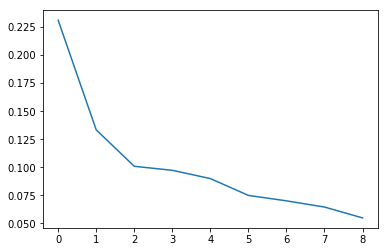

In [25]:
# Evaluate explained variance ratio -- it appears that the first component explains
# most of the data set. 
print(pca.explained_variance_ratio_)
plt.plot(pca.explained_variance_ratio_)

In [26]:
np.sum(pca.explained_variance_ratio_)

0.91644178152206091

In [27]:
# Create training and test sets.
offset = int(X_pca.shape[0] * 0.7)

# Put 90% of the data in the training set.
X_train, y_train = X_pca[:offset], y[:offset]

# And put 10% in the test set.
X_test, y_test = X_pca[offset:], y[offset:]

In [28]:
# Instantiate gradient boost using parameters from grid search
clf = ensemble.GradientBoostingClassifier(**gs.best_params_)

# Fit gradient boost to training data
clf.fit(X_train, y_train)

# Predict outcomes for training + test data
predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

# Accuracy tables.
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))


Training set accuracy:
Percent Type I errors: 0.04930179538330009
Percent Type II errors: 0.1816756910800798

Test set accuracy:
Percent Type I errors: 0.03291223404255319
Percent Type II errors: 0.40126329787234044


In [29]:
# Store results
t1_errors.append(test_tI_errors)
t2_errors.append(test_tII_errors)

## Conclusion

The best performance was achieved by dropping features that were found to be irrelevant to the target variable -- effectively reducing noise within the data set. However, this performance increase relative to the model's performance when fit on all of the data is trivial. 

In [31]:
# Store strings describing variations of feature sets
iterations = ['all_data','drop_irrev_features','mutual_info','chi2','pca']

In [32]:
# Create data frame 
results = pd.DataFrame()

In [33]:
# Store variations of feature sets
# with results and their respective Type I and Type II accuracy results on test data
results['iterations'] = iterations
results['type_1_errors'] = t1_errors
results['type_2_errors'] = t2_errors

In [40]:
# Create attribute to show total error for Type I and Type II errors
results['total_error'] = results['type_1_errors']+results['type_2_errors']

In [49]:
# View results
results.sort_values(['total_error'],ascending=[1])

,iterations,type_1_errors,type_2_errors,total_error
1,drop_irrev_features,0.028258,0.400266,0.428524
0,all_data,0.027261,0.403923,0.431184
4,pca,0.032912,0.401263,0.434176
2,mutual_info,0.026928,0.421543,0.448471
3,chi2,0.027593,0.423870,0.451463
